In [1]:
import pandas as pd
import numpy as np
from numpy import concatenate
from pandas import concat
from pandas import read_csv
from pandas import DataFrame
import tensorflow as tf
from tensorflow import keras
import os
import datetime
import IPython
import IPython.display
import plotly.express as px # to plot the time series plot
from sklearn import metrics # for the evaluation
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation,Flatten, LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Bidirectional, Input, Reshape, RepeatVector, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
%matplotlib inline
from scipy.stats import randint as sp_randint
np.random.seed(123) # for reproducibility
import warnings
warnings.filterwarnings('ignore')

In [2]:
datos = read_csv('Barrancabermeja_Lags.csv', encoding='latin-1', sep=";")

# Se eliminan las columnas de las variables que No se van a utilizar
datos = datos.drop(['Municipio', 'Año', 'Semana_Epi',
       'Temp_Seca_Max_Dia_Prom', 'Temp_Seca_Max_Dia_Prom_1',
       'Temp_Seca_Max_Dia_Prom_2', 'Temp_Seca_Max_Dia_Prom_3',
       'Temp_Seca_Max_Dia_Prom_4', 'Temp_Seca_Max_Dia_Prom_5',
       'Temp_Seca_Max_Dia_Prom_6', 'Temp_Seca_Max_Sem', 'Temp_Seca_Max_Sem_1',
       'Temp_Seca_Max_Sem_2', 'Temp_Seca_Max_Sem_3', 'Temp_Seca_Max_Sem_4',
       'Temp_Seca_Max_Sem_5', 'Temp_Seca_Max_Sem_6', 'Temp_Seca_Min_Dia_Prom',
       'Temp_Seca_Min_Dia_Prom_1', 'Temp_Seca_Min_Dia_Prom_4',
       'Temp_Seca_Min_Dia_Prom_5', 'Temp_Seca_Min_Sem', 'Temp_Seca_Min_Sem_1', 'Temp_Seca_Min_Sem_2',
       'Temp_Seca_Min_Sem_3', 'Temp_Seca_Min_Sem_4', 'Temp_Seca_Min_Sem_5',
       'Temp_Seca_Min_Sem_6', 'Prom_Dia_Preci', 'Prom_Dia_Preci_1',
       'Prom_Dia_Preci_2', 'Prom_Dia_Preci_3', 'Prom_Dia_Preci_4',
       'Prom_Dia_Preci_5', 'Prom_Dia_Preci_6', 'Total_Preci_Sem',
       'Total_Preci_Sem_1', 'Total_Preci_Sem_2', 'Total_Preci_Sem_3',
       'Total_Preci_Sem_4', 'Total_Preci_Sem_5', 'Total_Preci_Sem_6',
       'Temp_Max_Dia_Prom', 'Temp_Max_Dia_Prom_1', 'Temp_Max_Dia_Prom_2',
       'Temp_Max_Dia_Prom_3', 'Temp_Max_Dia_Prom_4', 'Temp_Max_Dia_Prom_5',
       'Temp_Max_Dia_Prom_6', 'Temp_Max_Sem', 'Temp_Max_Sem_1',
       'Temp_Max_Sem_2', 'Temp_Max_Sem_3', 'Temp_Max_Sem_4', 'Temp_Max_Sem_5',
       'Temp_Max_Sem_6', 'Temp_Min_Dia_Prom', 'Temp_Min_Dia_Prom_1',
       'Temp_Min_Dia_Prom_2', 'Temp_Min_Dia_Prom_3', 'Temp_Min_Dia_Prom_4',
       'Temp_Min_Dia_Prom_5', 'Temp_Min_Dia_Prom_6', 'Temp_Min_Sem',
       'Temp_Min_Sem_1', 'Temp_Min_Sem_2', 'Temp_Min_Sem_3', 'Temp_Min_Sem_4',
       'Temp_Min_Sem_5', 'Temp_Min_Sem_6', 'Hum_Rel_Max', 'Hum_Rel_Max_1',
       'Hum_Rel_Max_2', 'Hum_Rel_Max_3', 'Hum_Rel_Max_4', 'Hum_Rel_Max_5',
       'Hum_Rel_Max_6','Hum_Rel_Min_1', 'Hum_Rel_Min_2',
       'Hum_Rel_Min_3', 'Hum_Rel_Min_5','Temp_Seca_Min_Dia_Prom_3', 'Temp_Seca_Min_Dia_Prom_6',
                  'Temp_Seca_Min_Dia_Prom_2', 'Hum_Rel_Min_4',  ],axis=1)
datos.columns

Index(['Casos_Dengue', 'Hum_Rel_Min', 'Hum_Rel_Min_6'], dtype='object')

In [3]:
datos.isnull().sum()

Casos_Dengue      0
Hum_Rel_Min      28
Hum_Rel_Min_6    28
dtype: int64

In [4]:
#Se realiza la imputación de los datos
knnImputer = KNNImputer (missing_values=np.nan, n_neighbors=2, 
                         weights="uniform", metric="nan_euclidean")
# Ajustamos el modelo e imputamos los missing values
knnImputer.fit(datos[['Hum_Rel_Min']])
datos['Hum_Rel_Min'] = knnImputer.transform(datos[['Hum_Rel_Min']]).ravel()
knnImputer.fit(datos[['Hum_Rel_Min_6']])
datos['Hum_Rel_Min_6'] = knnImputer.transform(datos[['Hum_Rel_Min_6']]).ravel()

datos.shape

(624, 3)

In [5]:
train_size = int(len(datos) * 0.7)
test_size = len(datos) - train_size
train, test = datos.iloc[0:train_size], datos.iloc[train_size:len(datos)]
print(len(train), len(test))

436 188


In [6]:
f_columns = ['Hum_Rel_Min','Hum_Rel_Min_6']
f_transformer = MinMaxScaler(feature_range=(0, 1))
f_transformer = f_transformer.fit(train[f_columns].to_numpy())
train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())

In [7]:
dengue_transformer = MinMaxScaler(feature_range=(0, 1))
dengue_transformer = dengue_transformer.fit(train[['Casos_Dengue']])
train['Casos_Dengue'] = dengue_transformer.transform(train[['Casos_Dengue']])
test['Casos_Dengue'] = dengue_transformer.transform(test[['Casos_Dengue']])

In [8]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [9]:
time_steps = 7
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train, train.Casos_Dengue, time_steps)
X_test, y_test = create_dataset(test, test.Casos_Dengue, time_steps)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape )

(429, 7, 3) (429,) (181, 7, 3) (181,)


In [10]:
Barr_MLP_model_1 = keras.Sequential()

# CAPA DE ENTRADA
Barr_MLP_model_1.add(keras.layers.Flatten(input_shape=(X_train.shape[1], X_train.shape[2])))

    
Barr_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))
Barr_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))
Barr_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))
Barr_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))
Barr_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))
Barr_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))
Barr_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))

#CAPA DE SALIDA

Barr_MLP_model_1.add(keras.layers.Dense(1))


#COMPILACIÓN DEL MODELO
Barr_MLP_model_1.compile(optimizer="adam", loss = 'mse')


#Se utiliza la devolución de llamada ModelCheckpoint para guardar puntos de control con regularidad 
#y la EarlyStopping para interrumpir el entrenamiento cuando la pérdida de validación ya no mejore.
model_filepath = 'Barr_MLP_model_2.h5'
checkpoint = ModelCheckpoint(model_filepath, monitor = 'val_loss', verbose=0, save_best_only = True, mode='min')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')


#ENTRENAMIENTO DEL MODELO
history_MLP = Barr_MLP_model_1.fit(X_train,y_train, validation_data=(X_test,y_test), 
                                     verbose=2, epochs=100, callbacks=[monitor, checkpoint],shuffle=False)
Barr_MLP_model_1.load_weights(model_filepath)

Epoch 1/100
14/14 - 3s - loss: 0.1737 - val_loss: 0.0204 - 3s/epoch - 213ms/step
Epoch 2/100
14/14 - 0s - loss: 0.0191 - val_loss: 0.0128 - 160ms/epoch - 11ms/step
Epoch 3/100
14/14 - 0s - loss: 0.0221 - val_loss: 0.0087 - 161ms/epoch - 11ms/step
Epoch 4/100
14/14 - 0s - loss: 0.0294 - val_loss: 0.0107 - 79ms/epoch - 6ms/step
Epoch 5/100
14/14 - 0s - loss: 0.0268 - val_loss: 0.0172 - 94ms/epoch - 7ms/step
Epoch 6/100
14/14 - 0s - loss: 0.0177 - val_loss: 0.0063 - 157ms/epoch - 11ms/step
Epoch 7/100
14/14 - 0s - loss: 0.0101 - val_loss: 0.0045 - 157ms/epoch - 11ms/step
Epoch 8/100
14/14 - 0s - loss: 0.0112 - val_loss: 0.0043 - 157ms/epoch - 11ms/step
Epoch 9/100
14/14 - 0s - loss: 0.0106 - val_loss: 0.0036 - 157ms/epoch - 11ms/step
Epoch 10/100
14/14 - 0s - loss: 0.0110 - val_loss: 0.0042 - 94ms/epoch - 7ms/step
Epoch 11/100
14/14 - 0s - loss: 0.0102 - val_loss: 0.0032 - 157ms/epoch - 11ms/step
Epoch 12/100
14/14 - 0s - loss: 0.0120 - val_loss: 0.0044 - 108ms/epoch - 8ms/step
Epoch 13/1

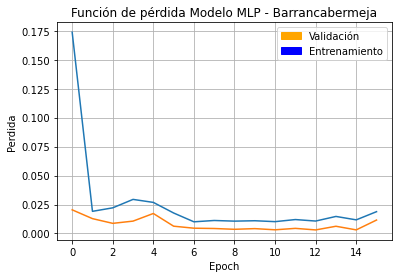

In [11]:
plt.figure(figsize=(6,4))
orange_patch = mpatches.Patch(color='orange', label='Validación')
blue_patch = mpatches.Patch(color='blue', label='Entrenamiento')
plt.legend(handles=[orange_patch, blue_patch])
plt.title('Función de pérdida Modelo MLP - Barrancabermeja')
plt.xlabel("Epoch")
plt.ylabel("Perdida")
plt.grid(True)
plt.plot(history_MLP.history['loss'])
plt.plot(history_MLP.history['val_loss'])
plt.show()

In [12]:
y_pred = Barr_MLP_model_1.predict(X_test)
y_train_inv = dengue_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = dengue_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = dengue_transformer.inverse_transform(y_pred.reshape(1, -1))
print(y_train_inv.shape)
print(y_test_inv.shape)
print(y_pred_inv.shape)

6/6 [==============================] - 0s 3ms/step
(1, 429)
(1, 181)
(1, 181)


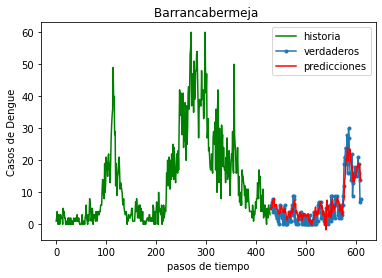

In [13]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="historia")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="verdaderos")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="predicciones")
plt.title('Barrancabermeja ')
plt.ylabel('Casos de Dengue')
plt.xlabel('pasos de tiempo')
plt.legend()
plt.show();

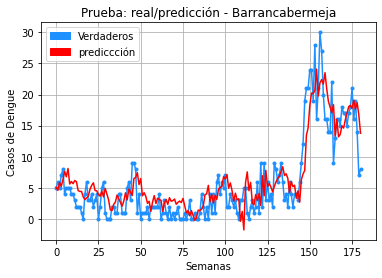

In [14]:
plt.title('Prueba: real/predicción - Barrancabermeja' )
plt.xlabel("Semanas")
plt.ylabel("Casos de Dengue")
plt.plot(y_test_inv.flatten(), marker='.', color= 'dodgerblue', label="Verdaderos")
plt.plot(y_pred_inv.flatten(), color= 'red', label="prediccción")
plt.grid(True)
green_patch = mpatches.Patch(color='dodgerblue', label="Verdaderos")
red_patch = mpatches.Patch(color='red', label="prediccción")
plt.legend(handles=[green_patch, red_patch])
plt.show()

In [15]:
score = np.sqrt(metrics.mean_squared_error(y_test_inv.flatten(), y_pred_inv.flatten()))
print("RMSE  Barranca       : {}".format(score))
print("MSE Barranca  = ", mean_squared_error(y_test_inv.flatten(), y_pred_inv.flatten()))
print("MAE Barranca = ", mean_absolute_error(y_test_inv.flatten(), y_pred_inv.flatten()))
print("r2_score Barranca  = ", r2_score(y_test_inv.flatten(), y_pred_inv.flatten()))
print("explained_variance_score Barranca  = ", explained_variance_score(y_test_inv.flatten(), y_pred_inv.flatten()))

RMSE  Barranca       : 3.3187798042101813
MSE Barranca  =  11.014299388833368
MAE Barranca =  2.6266034745215054
r2_score Barranca  =  0.7473534086912896
explained_variance_score Barranca  =  0.7610442088854937


In [16]:
# VISUALIZACIÓN DE LOS VALORES TESTEADOS VS LAS PREDICCIONES

resultados = pd.DataFrame({ 'Actuales':y_test_inv.flatten(), 'Predicciones': y_pred_inv.flatten()})
resultados['diferencia'] = resultados['Predicciones'] - resultados['Actuales']
resultados.head(60)

,Actuales,Predicciones,diferencia
0,5.0,5.120232,0.120232
1,6.0,4.603704,-1.396296
2,5.0,5.900197,0.900197
3,7.0,5.257583,-1.742417
4,8.0,6.296119,-1.703881
5,4.0,7.652889,3.652889
6,5.0,6.785683,1.785683
7,5.0,8.122512,3.122512
8,5.0,5.627704,0.627704
9,4.0,6.027069,2.027069


In [17]:
resultados.tail(60)

,Actuales,Predicciones,diferencia
121,9.0,2.184654,-6.815346
122,2.0,6.958815,4.958815
123,9.0,3.741305,-5.258695
124,3.0,7.827419,4.827419
125,6.0,5.212280,-0.787720
126,3.0,5.714809,2.714809
127,4.0,5.157411,1.157411
128,2.0,4.370775,2.370775
129,9.0,5.221473,-3.778527
130,8.0,5.975516,-2.024484
